<a href="https://colab.research.google.com/github/RiRyCasals/tech-AI-project/blob/main/02_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRCNN, Skip Connection
---

## SRCNNとは
---

SRCNN : Super-Resolution Convolutional Neural Network

2015年に論文で発表された，畳み込み層を3層重ねただけのシンプルなネットワーク．

![image](https://sorabatake.jp/wp-content/uploads/2020/05/image3-1-1300x472.png)

## Skip Connection
---

中間層をスキップするような構造をネットワークに取り入れ，圧縮前の情報を保管する働きをする．

![image](https://qiita-user-contents.imgix.net/https%3A%2F%2Fqiita-image-store.s3.amazonaws.com%2F0%2F145675%2Fcb9ac858-4911-efaf-7320-78ba0d139f35.png?ixlib=rb-4.0.0&auto=format&gif-q=60&q=75&s=57336c672741f977f56ae226b7c960a1)

# 超解像
---

解像度の低い画像を受け取り，解像度の高い画像を生成する技術．

以下，CAEとSkipConnectionを組み合わせたモデルをSCCAEと呼ぶ．

このノートブックでは次の2つのモデルを利用して超解像を行う．

- SRCNN
- SCCNN

## データの作成
---

1. データセットのダウンロード
2. 低解像度データの生成

## データセットのダウンロード及び作成
---

In [268]:
!curl -OL http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar xf images.tar
print("\nnumber of images : ", end="")
!ls -lR /content/Images/ | grep -c 'jpg$'
!rm /content/images.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756M  100  756M    0     0  32.7M      0  0:00:23  0:00:23 --:--:-- 38.0M

number of images : 20580


In [269]:
!mkdir -p /content/datasets/train && mkdir -p /content/datasets/test
!cp /content/Images/n0209[0-9]*/*.jpg /content/datasets/train
!cp /content/Images/n0211[0-9]*/*.jpg /content/datasets/test
!rm -rf /content/Images/

In [270]:
print("number of train image : ", end="")
!ls /content/datasets/train | grep -c 'jpg$'

print("number of  test image : ", end="")
!ls /content/datasets/test | grep -c 'jpg$'

number of train image : 7383
number of  test image : 3922


In [271]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

(331, 500, 3)


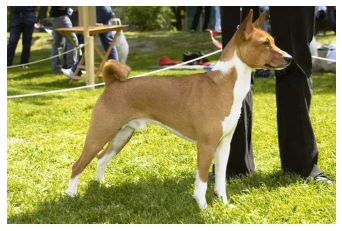

(500, 375, 3)


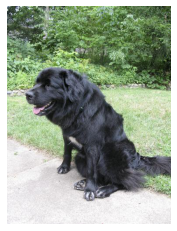

(227, 305, 3)


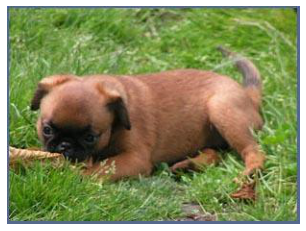

In [272]:
train_image_path = glob.glob("/content/datasets/train/*.jpg")
test_image_path = glob.glob("/content/datasets/test/*.jpg")

for i, path in enumerate(test_image_path):
    if i == 3:
        break
    image_array = np.array(Image.open(path))
    print(image_array.shape)
    plt.imshow(image_array)
    plt.axis('off')
    plt.show()

## 低解像度画像の作成
---

In [273]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator

In [274]:
def drop_resolution(x, scale=3.0):
    small_size = (int(x.shape[0] / scale), int(x.shape[1] / scale))
    image = array_to_img(x)
    small_image = image.resize(small_size, 3)
    return img_to_array(small_image.resize(image.size, 3))

def data_generator(data_dir, mode, scale=2.0, target_size=(200, 200), batch_size=32, shuffle=True):
    for images in ImageDataGenerator().flow_from_directory(directory=data_dir,
                                                         classes=[mode],
                                                         class_mode=None,
                                                         color_mode="rgb",
                                                         target_size=target_size,
                                                         batch_size=batch_size,
                                                         shuffle=shuffle):
        x = np.array([drop_resolution(image, scale) for image in images])
        yield x/255., images/255.

In [ ]:
DATA_DIR = "/content/datasets/"
N_TRAIN_DATA = len(train_image_path)
N_TEST_DATA = len(test_image_path)
BATCH_SIZE = 64

train_data_generator = data_generator(DATA_DIR, "train", batch_size=BATCH_SIZE)

test_x, test_y = next(data_generator(DATA_DIR, "test", batch_size=N_TEST_DATA, shuffle=False))

Found 3922 images belonging to 1 classes.


In [ ]:
def show_images_2columns(image_list1, image_list2, n=5):
    for i in range(n):
        plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(image_list1[0])
        plt.axis("off")
        plt.subplot(122)
        plt.imshow(image_list2[0])
        plt.axis("off")
        plt.show()

def show_images_3columns(image_list1, image_list2, image_list3, n=5):
    for i in range(n):
        plt.figure(figsize=(10, 10))
        plt.subplot(131)
        plt.imshow(image_list1[0])
        plt.axis("off")
        plt.subplot(132)
        plt.imshow(image_list2[0])
        plt.axis("off")
        plt.subplot(133)
        plt.imshow(image_list3[0])
        plt.axis("off")
        plt.show()

In [ ]:
show_images_2columns(test_x, test_y, n=1)

## RSCNNを用いた超解像
---

1. RSCNNモデルの構築
2. 学習と予測

### PSNR
---

ピーク信号対雑音比 : Peak signal-to-noise ratio

$$ PSNR = 10\log_{10}{\frac{MAX^2}{MSE}} $$

今回は $MAX=1$ なので

$$
\begin{eqnarray}
PSNR & = 10\log_{10}{\frac{MAX^2}{MSE}} \\
& = -10\log_{10}{MSE} \\
& = -10\frac{\log{MSE}}{\log{10}}
\end{eqnarray}
$$

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D

In [ ]:
srcnn = Sequential()

srcnn.add(Conv2D(64, kernel_size=9, padding="same", activation="relu", input_shape=(None, None, 3)))
srcnn.add(Conv2D(32, kernel_size=1, padding="same", activation="relu"))
srcnn.add(Conv2D(3, kernel_size=5, padding="same"))

srcnn.summary()

In [ ]:
def psnr(y_true, y_pred):
    return - 10 * K.log(K.mean(K.flatten((y_true - y_pred))**2)) / np.log(10)

In [ ]:
srcnn.compile(loss="mean_squared_error", optimizer="adam", metrics=[psnr])

In [15]:
#Colab上だとリソースが足りなくなる可能性が高いので行わない
# srcnn.fit_generator(train_data_generator, validation_data=(test_x, test_y), steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE, epochs=50)

Found 7383 images belonging to 1 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
115/115 [==============================] - 76s 541ms/step - loss: 0.0150 - psnr: 19.3525 - val_loss: 0.0072 - val_psnr: 21.4910
Epoch 2/50
115/115 [==============================] - 59s 508ms/step - loss: 0.0058 - psnr: 22.3957 - val_loss: 0.0055 - val_psnr: 22.7019
Epoch 3/50
115/115 [==============================] - 56s 486ms/step - loss: 0.0053 - psnr: 22.7819 - val_loss: 0.0050 - val_psnr: 23.1113
Epoch 4/50
115/115 [==============================] - 54s 472ms/step - loss: 0.0048 - psnr: 23.2463 - val_loss: 0.0050 - val_psnr: 23.1471
Epoch 5/50
115/115 [==============================] - 54s 469ms/step - loss: 0.0045 - psnr: 23.4532 - val_loss: 0.0049 - val_psnr: 23.2476
Epoch 6/50
115/115 [==============================] - 54s 475ms/step - loss: 0.0044 - psnr: 23.5690 - val_loss: 0.0045 - val_psnr: 23.6409
Epoch 7/50
115/115 [==============================] - 55s 477ms/step - loss: 0.0042 - psnr: 23.7399 - val_loss: 0.0043 - val_psnr: 23.8121
Epoch 8/50
115/115 [=======

In [ ]:
# 学習済みのモデルの呼び出し
from tensorflow.keras.models import load_model

In [ ]:
#!mkdir /content/models
#!curl -O モデルのパス -o /content/models/srcnn.h5
srcnn = load_model("/content/models/srcnn.h5")

In [ ]:
pred = srcnn.predict(test_x)

In [ ]:
show_images_3columns(test_x, test_y, pred)

## SCCNNを用いた超解像
---

1. SCCAEモデルの構築
2. 学習と予測